# ADXVMA 

https://www.linnsoft.com/techind/adxvma

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# yahoo finance is used to fetch data 
import yfinance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AAPL'
start = '2018-01-01'
end = '2019-01-01'

# Read data 
df = yf.download(symbol,start,end)
df.index = pd.Index(df.index.date, name="Date")

# View Columns
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.888065,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.880955,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.070839,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.538441,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.384159,82271200


In [3]:
n = 14 # Number of Periods

## Calculate the ADX(14)
def adxvma(data, period=n, multiplier=2, offset=0.5):
    tr = pd.DataFrame(index=data.index)
    tr['hl'] = abs(data['High'] - data['Low'])
    tr['hc'] = abs(data['High'] - data['Close'].shift())
    tr['lc'] = abs(data['Low'] - data['Close'].shift())
    tr['tr'] = tr.max(axis=1)
    atr = tr['tr'].rolling(period).mean()

    dx = pd.DataFrame(index=data.index)
    dx['hd'] = data['High'] - data['High'].shift()
    dx['ld'] = data['Low'].shift() - data['Low']
    dx['plus_dm'] = np.where((dx['hd'] > 0) & (dx['hd'] > dx['ld']), dx['hd'], 0)
    dx['minus_dm'] = np.where((dx['ld'] > 0) & (dx['ld'] > dx['hd']), dx['ld'], 0)
    dx['plus_di'] = 100 * dx['plus_dm'].rolling(period).sum() / atr
    dx['minus_di'] = 100 * dx['minus_dm'].rolling(period).sum() / atr
    dx['dx'] = 100 * abs(dx['plus_di'] - dx['minus_di']) / (dx['plus_di'] + dx['minus_di'])
    adxvma = dx['dx'] * multiplier + data['Close'].ewm(alpha=1/(period*offset)).mean() * (1 - multiplier)

    return adxvma

In [4]:
df['ADXVMA'] = adxvma(df)

In [5]:
df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume,ADXVMA
Date,,,,,,,
2018-01-22,44.325001,44.445000,44.150002,44.250000,42.013172,108434400,51.386220
2018-01-23,44.325001,44.860001,44.205002,44.259998,42.022659,130756400,62.457940
2018-01-24,44.312500,44.325001,43.299999,43.555000,41.353298,204420400,-15.050723
2018-01-25,43.627499,43.737499,42.632500,42.777500,40.615105,166116000,-41.857707
2018-01-26,43.000000,43.000000,42.514999,42.877499,40.710049,156572000,-15.571642


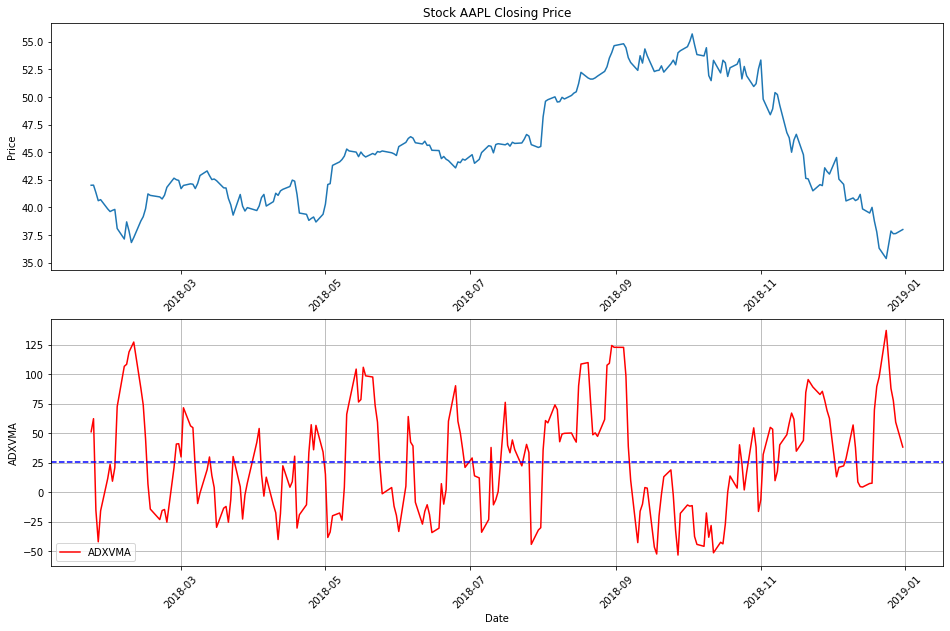

In [6]:
fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot(2, 1, 1)
ax1.plot(df['Adj Close'])
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')
ax1.tick_params(axis='x', rotation=45)

ax2 = plt.subplot(2, 1, 2)
ax2.plot(df['ADXVMA'] , label='ADXVMA', color='red')
ax2.axhline(y=df['ADXVMA'].mean(), color='blue', linestyle='--')
ax2.grid()
ax2.set_ylabel('ADXVMA')
ax2.set_xlabel('Date')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(loc='best')

## Candlestick with ADXVMA

In [7]:
from matplotlib import dates as mdates
import datetime as dt

dfc = df.copy()
dfc['VolumePositive'] = dfc['Open'] < dfc['Adj Close']
#dfc = dfc.dropna()
dfc = dfc.reset_index()
dfc['Date'] = pd.to_datetime(dfc['Date'])
dfc['Date'] = dfc['Date'].apply(mdates.date2num)
dfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ADXVMA,VolumePositive
0,736716.0,44.325001,44.445000,44.150002,44.250000,42.013172,108434400,51.386220,False
1,736717.0,44.325001,44.860001,44.205002,44.259998,42.022659,130756400,62.457940,False
2,736718.0,44.312500,44.325001,43.299999,43.555000,41.353298,204420400,-15.050723,False
3,736719.0,43.627499,43.737499,42.632500,42.777500,40.615105,166116000,-41.857707,False
4,736720.0,43.000000,43.000000,42.514999,42.877499,40.710049,156572000,-15.571642,False


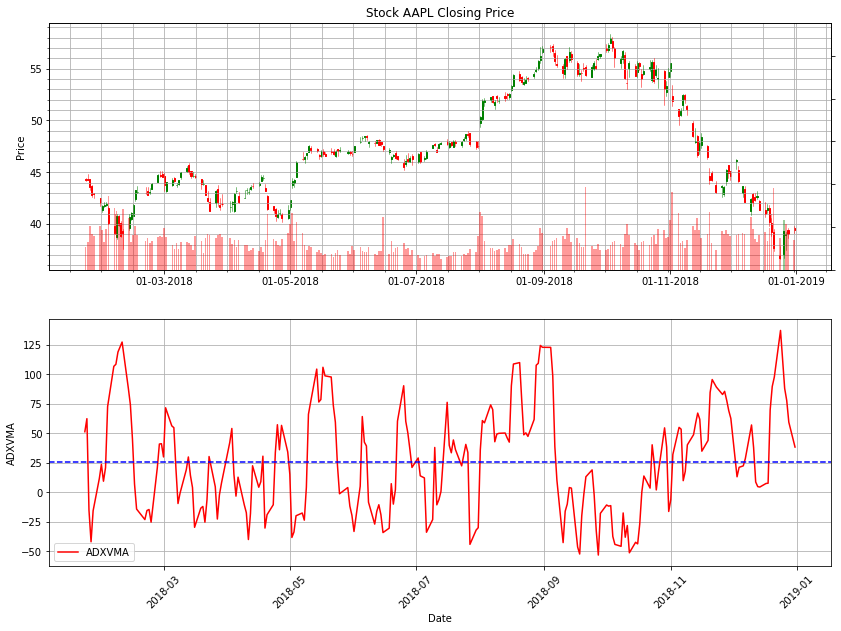

In [8]:
from mplfinance.original_flavor import candlestick_ohlc

fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(2, 1, 1)
candlestick_ohlc(ax1,dfc.values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3*df.Volume.max())
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(df['ADXVMA'] , label='ADXVMA', color='red')
ax2.axhline(y=df['ADXVMA'].mean(), color='blue', linestyle='--')
ax2.grid()
ax2.set_ylabel('ADXVMA')
ax2.set_xlabel('Date')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(loc='best')